## What makes a playlist successful?

**Analysis**

* Simple metric (dependent variable)
    * mau
    * mau_previous_month
    * mau_both_months
    * monthly_stream30s
    * stream30s
* Design metric (dependent variable)
    * 30s listens/tot listens (listen conversions)
    * Users both months/users prev month (user conversions)
    * Best small time performers (less than X total monthly listens + high conversion)
    * Best new user playlist (owner has only 1 popular playlist)
* Define "top"
    * Top 10%
        * mau_previous_month: 9.0
        * mau_both_months: 2.0
        * mau: 9.0
        * monthly_stream30s: 432.0
        * stream30s: 17.0
    * Top 1%
        * mau_previous_month: 130.0
        * mau_both_months: 19.0
        * mau: 143.0
        * monthly_stream30s: 2843.0
        * stream30s: 113.0
* Independent variables
    * moods and genres (categorical)
    * number of tracks, albums, artists, and local tracks (continuous)
        
The analysis will consist of:

1. understand the distribution characteristics of the dependent and independent variables
2. quantify the dependency of the dependent/independent variables for each of the simple and design metrics
    1. chi-square test
    2. bootstrap/t-test

**Key Conclusions**

for the simple metrics, key genres and moods were **Romantic, Latin, Children's, Lively, Traditional, and Jazz**. Playlists that included these genres/moods had a positive multiplier effect (usually in the vicinicty of 2x more likely) on the key simple metric (i.e. playlists with latin as a primary genre were 2.5x more likely to be in the top 10% of streams longer than 30 seconds)

skippers - is this associated with the current playlist 

| Column Name             | Description                                                                                              |
|-------------------------|----------------------------------------------------------------------------------------------------------|
| playlist_uri            | The key, Spotify uri of the playlist                                                                     |
| owner                   | Playlist owner, Spotify username                                                                         |
| streams                 | Number of streams from the playlist today                                                                |
| stream30s               | Number of streams over 30 seconds from playlist today                                                    |
| dau                     | Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today               |
| wau                     | Number of Weekly Active Users, i.e. users with a stream over 30 seconds from playlist in past week       |
| mau                     | Number of Monthly Active Users, i.e. users with a stream over 30 seconds from playlist in the past month |
| mau_previous_months     | Number of Monthly Active users in the month prior to this one                                            |
| mau_both_months         | Number of users that were active on the playlist both this and the previous month                        |
| users                   | Number of users streaming (all streams) from this playlist this month                                    |
| skippers                | Number of users who skipped more than 90 percent of their streams today                                  |
| owner_country           | Country of the playlist owner                                                                            |
| n_tracks                | Number of tracks in playlist                                                                             |
| n_local_tracks          | Change in number of tracks on playlist since yesterday                                                   |
| n_artists               | Number of unique artists in playlist                                                                     |
| n_albums                | Number of unique albums in playlist                                                                      |
| monthly_stream30s       | Number of streams over 30 seconds this month                                                             |
| monthly_owner_stream30s | Number of streams over 30 seconds by playlist owner this month                                           |
| tokens                  | List of playlist title tokens, stopwords and punctuation removed                                         |
| genre_1                 | No. 1 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| genre_2                 | No. 2 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| genre_3                 | No. 3 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| mood_1                  | No. 1 Mood by weight of playlist tracks, from Gracenote metadata                                         |
| mood_2                  | No. 2 Mood by weight of playlist tracks, from Gracenote metadata                                         |
| mood_3                  | No. 3 Mood by weight of playlist tracks, from Gracenote metadata                                         |

## Imports

In [1]:
# basic packages
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import random
import copy

# visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import graphviz 

# stats packages
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

# sklearn modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture

# sklearn evaluation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score


In [2]:
df = pd.read_csv("../../data/playlist_summary_external-4.txt", delimiter='\t')

#### Putting it All Together

In [3]:
sub_targets = ['mau_previous_month', 'mau_both_months', 'monthly_stream30s', 'stream30s']
des_features = ['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']

#### Models (Multi-Feature Analysis)

##### Deciles - Random Forest

In [ ]:
sub_targets

In [ ]:
target = sub_targets[-2]

In [ ]:
y = df[target].values
labels = y.copy()
names = []
for idx, quant in zip(range(11), np.linspace(0, 1, num=11)):
    if idx == 0:
        prev = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

In [ ]:
names

In [ ]:
X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

In [ ]:
y_hat_test = model.predict(X_test)
print(f"Train Acc: {accuracy_score(y_test, y_hat_test):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

In [ ]:
print(classification_report(y_test, y_hat_test, zero_division=0))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax, xticklabels=names, yticklabels=names)

In [ ]:
# grab feature importances
imp = model.feature_importances_

# their std
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# build feature names
feature_names = con_features + list(enc.get_feature_names_out())

# create new dataframe
feat = pd.DataFrame([feature_names, imp, std]).T
feat.columns = ['feature', 'importance', 'std']
feat = feat.sort_values('importance', ascending=False)
feat = feat.reset_index(drop=True)
feat.dropna(inplace=True)
feat.head(20)

##### Quartiles - Random Forest

In [ ]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
lim = 5
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx == 0:
        prev = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train)

### Asses Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

##### Binary, 90th Percentile, Random Forest

In [ ]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 5
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        weights[(y > np.quantile(y, prev))
              &(y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
        
    prev = quant
y = labels

In [ ]:
### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, weights, random_state=42, train_size=0.8)


### Strateification Code

# strat_y0_idx = np.array(random.sample(list(np.argwhere(y_train==3).reshape(-1)), np.unique(y_train, return_counts=True)[1][1]))
# strat_y1_idx = np.argwhere(y_train==4).reshape(-1)
# strat_idx = np.hstack((strat_y0_idx, strat_y1_idx))
# X_train = X_train[strat_idx]
# y_train = y_train[strat_idx]

In [ ]:
### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train)

### Assess Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

##### Forward Selection Model

In [ ]:
### y
print(target)
y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = 0
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              & (labels <= np.quantile(y, quant))] = 1
        weights[(y > np.quantile(y, prev))
              & (y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

#### X

X = df[des_features + con_features]

enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((np.ones((X_con.shape[0], 1)), X_con, X_cat))
feature_names = ['intercept'] + con_features + list(enc.get_feature_names_out())

data = pd.DataFrame(X, columns=feature_names)
print(names)

In [ ]:
def add_feature(feature_names, basemodel, data, y, r2max=0, model='linear', disp=0):
    feature_max = None
    bestsum = None
    newmodel = None
    for feature in feature_names:
        basemodel[feature] = data[feature]
        X2 = basemodel.values
        est = Logit(y, X2)
        est2 = est.fit(disp=0)
        summ = est2.summary()
        score = float(str(pd.DataFrame(summ.tables[0]).loc[3, 3]))
        if (score > r2max) and not (est2.pvalues > cutoff).any():
            r2max = score
            feature_max = feature
            bestsum = est2.summary()
            newmodel = basemodel.copy()
            if disp == 1:
                print(f"new r2max, {feature_max}, {r2max}")
        basemodel.drop(labels = feature, axis = 1, inplace = True)
    return r2max, feature_max, bestsum, newmodel

In [ ]:
candidates = feature_names.copy()
basemodel = pd.DataFrame()
r2max = 0

In [ ]:
with open("canidates.txt", "w+") as f:
    file_data = f.read()
    for i in candidates:
        f.write(f"{i}\n")

In [ ]:
basemodel.to_csv("basemodel.csv")

In [ ]:
with open("canidates.txt", "r") as f:
    # file_data = f.read()
    new = []
    for line in f:
        current_place = line[:-1]
        new.append(current_place)

In [ ]:
new = pd.read_csv("basemodel.csv", index_col=0)

In [ ]:
with open("fwd_selection_results.txt", "r+") as f:
    for line in f:
        pass
    lastline = line[:-1]
    stuff = lastline.split(", ")
    new = float(stuff[-1])


In [ ]:
new

In [ ]:
while True:
    newr2max, feature_max, bestsum, newmodel = add_feature(
        feature_names=candidates, 
        basemodel=basemodel, 
        data=data, 
        y=y,
        r2max=r2max)    
    if newr2max > r2max:
        r2max = newr2max
        print(f"new r2max, {feature_max}, {r2max}")
        with open("fwd_selection_results.txt", "a+") as f:
            file_data = f.read()
            f.write(f"new r2max, {feature_max}, {r2max}\n")
        candidates.remove(feature_max)
        with open("canidates.txt", "w+") as f:
            file_data = f.read()
            for i in candidates:
                f.write(f"{i}\n")
        basemodel = newmodel
        basemodel.to_csv("basemodel.csv")
        continue
    else:
        break

In [ ]:
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
res_df

##### Binary, 99th Percentile

In [ ]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        weights[(y > np.quantile(y, prev))
              &(y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
        
    prev = quant
y = labels

### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, weights, random_state=42, train_size=0.8)

### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train, weight_train)

### Asses Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

## Other Metrics

* 30s listens/tot listens (listen conversions) _also like a bounce rate_
* Users both months/users prev month (user conversions)
    * combine with mau > mau_previous_month
* Best small time performers (less than X total monthly listens + high conversion)
* Best new user playlist (owner has only 1 popular playlist)

### Listen and User Conversions, MAU Growing

In [4]:
df['listen_conversions'] = df['stream30s'] / df['streams']
df['listen_conversions'].fillna(value=0, inplace=True)

df['user_retention'] = df['mau_both_months'] / df['mau_previous_month']
df['user_retention'].fillna(value=0, inplace=True)

df['user_conversions'] = df['mau'] / df['users']
df['user_conversions'].fillna(value=0, inplace=True)


df['mau_growing'] = df['mau'] > df['mau_previous_month']
df['mau_growth'] = df['mau'] / df['mau_previous_month']
df['mau_growth'].fillna(value=0, inplace=True)
df['mau_growth'].replace([np.inf, -np.inf], 1, inplace=True)

In [5]:
new_metrics = ['listen_conversions', 'user_conversions', 'user_retention', 'mau_growth']

In [6]:
df[new_metrics].describe()

,listen_conversions,user_conversions,user_retention,mau_growth
count,403366.000000,403366.000000,403366.000000,403366.000000
mean,0.334701,0.724072,0.571070,1.513218
std,0.399968,0.261708,0.392073,17.459669
min,0.000000,0.020348,0.000000,0.031250
25%,0.000000,0.500000,0.200000,1.000000
50%,0.000000,0.666667,0.500000,1.066667
75%,0.730769,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,7859.000000


<AxesSubplot:ylabel='Frequency'>

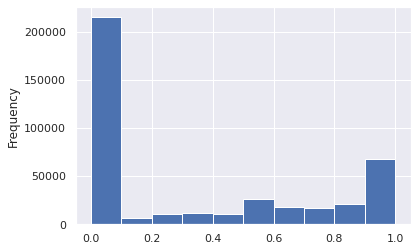

In [7]:
df['listen_conversions'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

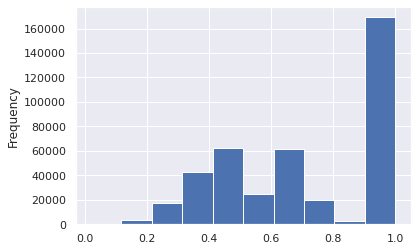

In [8]:
df['user_conversions'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

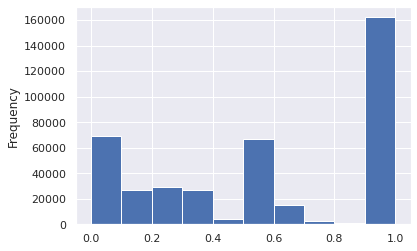

In [9]:
df['user_retention'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

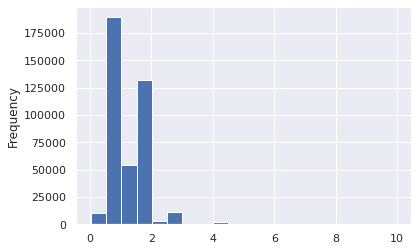

In [10]:
df.loc[df['mau_growth'] < 10]['mau_growth'].plot(kind='hist', bins=20)

<AxesSubplot:>

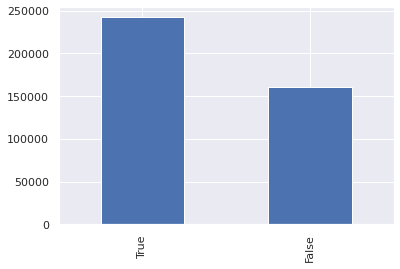

In [11]:
df['mau_growing'].value_counts().plot(kind='bar')

In [12]:
df['new_success'] = df[new_metrics].apply(lambda x: (x > 0.5) if (max(x) == 1) else (x > 1)).all(axis=1)

In [13]:
df['new_success'].value_counts()

False    362869
True      40497
Name: new_success, dtype: int64

In [14]:
df.loc[df['new_success'] == True]

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3,listen_conversions,user_retention,user_conversions,mau_growing,mau_growth,new_success
14,spotify:user:9a3580868994077be27d244788d494cd:...,9a3580868994077be27d244788d494cd,28,15,1,1,2,1,1,2,0,US,321,0,170,205,83,77,"[""sunny"", ""daze""]",Alternative,Indie Rock,Electronica,Brooding,Excited,Sensual,0.535714,1.0,1.000000,True,2.000000,True
18,spotify:user:7abbdbd3119687473b8f2986e73e2ad6:...,7abbdbd3119687473b8f2986e73e2ad6,9,5,1,2,2,1,1,2,0,US,373,8,1,1,18,11,[],Pop,Alternative,Indie Rock,Empowering,Excited,Urgent,0.555556,1.0,1.000000,True,2.000000,True
20,spotify:user:838141e861005b6a955cb389c19671a5:...,838141e861005b6a955cb389c19671a5,32,25,2,3,4,3,3,5,1,US,904,0,81,125,327,253,"[""metalcore"", ""forever""]",Punk,Metal,Rock,Defiant,Urgent,Aggressive,0.781250,1.0,0.800000,True,1.333333,True
36,spotify:user:2217942070bcaa5f1e651e27744b4402:...,2217942070bcaa5f1e651e27744b4402,18,17,1,2,4,3,3,5,1,US,141,1,122,131,567,0,"[""chill""]",Rap,Dance & House,Alternative,Excited,Defiant,Energizing,0.944444,1.0,0.800000,True,1.333333,True
59,spotify:user:dfde15dd16b4ad87a75036276b4c9f66:...,dfde15dd16b4ad87a75036276b4c9f66,5,5,1,1,2,1,1,3,0,US,84,0,73,78,254,239,"[""vegas""]",Rock,Pop,R&B,Upbeat,Excited,Empowering,1.000000,1.0,0.666667,True,2.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403329,spotify:user:358b83239c6a2557fbfb053330d49a41:...,358b83239c6a2557fbfb053330d49a41,4,4,1,1,3,1,1,3,0,US,33,0,28,31,271,32,"[""one"", ""dirt"", ""road""]",Country & Folk,Rock,-,Yearning,Empowering,Gritty,1.000000,1.0,1.000000,True,3.000000,True
403336,spotify:user:a0781a2de47beb8bd693f3022f316327:...,a0781a2de47beb8bd693f3022f316327,856,855,3,10,10,5,5,10,0,US,168,0,6,9,33747,1391,"[""evning"", ""song""]",-,-,-,-,-,-,0.998832,1.0,1.000000,True,2.000000,True
403338,spotify:user:06f6dd666f1bbf9148c792b87ed4d22f:...,06f6dd666f1bbf9148c792b87ed4d22f,5,4,1,1,2,1,1,2,0,US,59,0,34,46,21,9,"[""rhc""]",Religious,Pop,Alternative,Empowering,Upbeat,Brooding,0.800000,1.0,1.000000,True,2.000000,True
403348,spotify:user:c6af258245d55221cebedb1175f08d83:...,c6af258245d55221cebedb1175f08d83,13,11,1,1,2,1,1,2,0,US,31,0,30,29,208,206,"[""zumba"", ""val"", ""silva"", ""playlist""]",Latin,Pop,Dance & House,Aggressive,Excited,Defiant,0.846154,1.0,1.000000,True,2.000000,True


In [15]:
chidf = pd.DataFrame()
target = 'new_success'
chidf[target] = df[target]
# quant_value = 0.90
# tar_value = np.quantile(chidf[target], quant_value)
# chidf[target] = chidf[target] > tar_value
chisum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]

    for grp_label in df[ind].unique():
    # grp_label = df[ind].unique()[0]
        try:
            cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
            chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
            ratio = cTable[1]/cTable[0]
            pos = ratio[1]/ratio[0]
            chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
        except:
            pass

chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

In [16]:
chisum.loc[chisum['reject null'] == True].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
6,genre_1,Dance & House,231.225731,3.221322e-52,"[[334768, 28101], [36487, 4010]]",1.309267,True
2,genre_1,Indie Rock,386.328998,5.212769e-86,"[[300809, 62060], [31986, 8511]]",1.289733,True
3,mood_1,Excited,289.821405,5.438394e-65,"[[306376, 56493], [32871, 7626]]",1.258184,True
4,mood_1,Defiant,285.014998,6.064223e-64,"[[291222, 71647], [31065, 9432]]",1.234123,True
16,genre_2,Electronica,124.733558,5.820843e-29,"[[335186, 27683], [36772, 3725]]",1.226540,True
...,...,...,...,...,...,...,...
70,mood_1,Somber,30.852148,2.784538e-08,"[[361994, 875], [40456, 41]]",0.419270,True
0,genre_3,-,1404.327669,2.410008e-307,"[[324633, 38236], [38610, 1887]]",0.414947,True
1,genre_2,-,861.809401,1.968786e-189,"[[342541, 20328], [39619, 878]]",0.373430,True
24,mood_1,Other,81.806778,1.500630e-19,"[[361232, 1637], [40439, 58]]",0.316494,True


In [17]:
chisum.loc[chisum['reject null'] == True].sort_values('multiplier', ascending=True)[:20]

,feature,group,chi,p-value,cTable,multiplier,reject null
42,genre_1,Spoken & Audio,58.779116,1.764037e-14,"[[361755, 1114], [40460, 37]]",0.296965,True
24,mood_1,Other,81.806778,1.500630e-19,"[[361232, 1637], [40439, 58]]",0.316494,True
1,genre_2,-,861.809401,1.968786e-189,"[[342541, 20328], [39619, 878]]",0.373430,True
0,genre_3,-,1404.327669,2.410008e-307,"[[324633, 38236], [38610, 1887]]",0.414947,True
70,mood_1,Somber,30.852148,2.784538e-08,"[[361994, 875], [40456, 41]]",0.419270,True
73,genre_1,Easy Listening,30.613123,3.149562e-08,"[[361984, 885], [40455, 42]]",0.424642,True
40,mood_2,-,60.796108,6.330294e-15,"[[361087, 1782], [40411, 86]]",0.431224,True
43,mood_1,-,57.600397,3.211607e-14,"[[361161, 1708], [40414, 83]]",0.434269,True
37,mood_3,-,64.489845,9.703118e-16,"[[360957, 1912], [40404, 93]]",0.434536,True
48,genre_1,Children's,52.188042,5.043231e-13,"[[361298, 1571], [40420, 77]]",0.438111,True


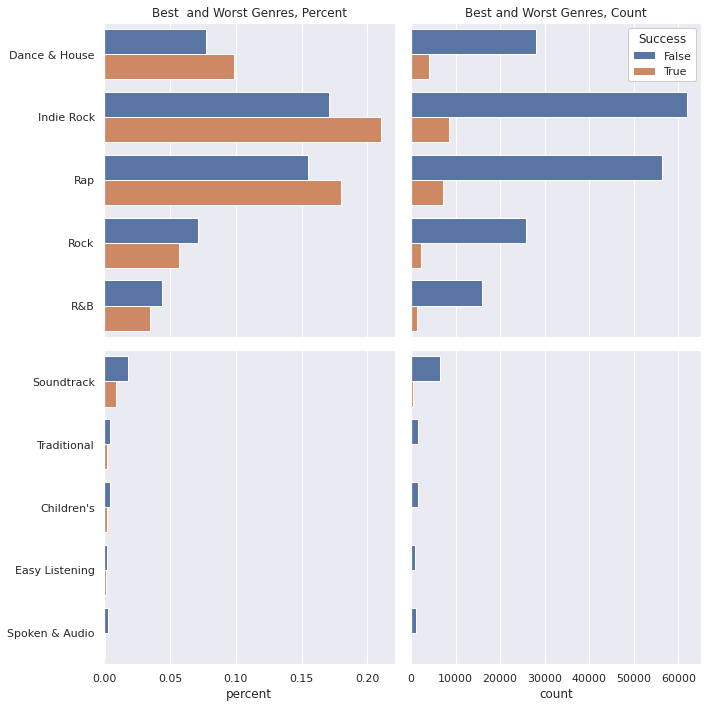

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col', sharey='row')

ind_feature = 'genre_1'
target = 'new_success'

genre_list = chisum.loc[(chisum['feature'] == ind_feature)
                       & (chisum['reject null'] == True)].sort_values('multiplier', ascending=False)['group'].values



chisum.loc[(chisum['feature'] == ind_feature)
                       & (chisum['reject null'] == True)].sort_values('multiplier', ascending=False).to_excel('table2.xlsx')

dff = pd.DataFrame(df.groupby([ind_feature])[target].value_counts(sort=False))
dff.columns = ['percent']
dff = dff.reset_index()
dff.loc[dff[target] == True, 'percent'] = dff.loc[dff[target] == True, 'percent'] / dff.loc[dff[target] == True, 'percent'].sum() 
dff.loc[dff[target] == False, 'percent'] = dff.loc[dff[target] == False, 'percent'] / dff.loc[dff[target] == False, 'percent'].sum() 
dff = dff.set_index(ind_feature).loc[genre_list,:]
dff = dff.reset_index()

sns.barplot(data=dff.iloc[:10,:], hue=target, y=ind_feature, x='percent', ax=ax[0,0])
ax[0,0].set_title('Best  and Worst Genres, Percent')
ax[0,0].set_ylabel('')
ax[0,0].set_xlabel('')
sns.barplot(data=dff.iloc[-10:,:], hue=target, y=ind_feature, x='percent', ax=ax[1,0])
# ax[1,0].set_title('Worst Primary Genres')
ax[1,0].set_ylabel('')

dff = pd.DataFrame(df.groupby([ind_feature])[target].value_counts(sort=False))
dff.columns = ['count']
dff = dff.reset_index()
# dff.loc[dff[target] == True, 'percent'] = dff.loc[dff[target] == True, 'percent'] / dff.loc[dff[target] == True, 'percent'].sum() 
# dff.loc[dff[target] == False, 'percent'] = dff.loc[dff[target] == False, 'percent'] / dff.loc[dff[target] == False, 'percent'].sum() 
dff = dff.set_index(ind_feature).loc[genre_list,:]
dff = dff.reset_index()

# fix, ax = plt.subplots(2, 2, figsize=(10,10))
sns.barplot(data=dff.iloc[:10,:], hue=target, y=ind_feature, x='count', ax=ax[0,1])
ax[0,1].set_title('Best and Worst Genres, Count')
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')
sns.barplot(data=dff.iloc[-10:,:], hue=target, y=ind_feature, x='count', ax=ax[1,1])
# ax[1,1].set_title('Worst Primary Genres')
ax[1,1].set_ylabel('')
plt.tight_layout()

ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[0,1].legend(framealpha=1, facecolor='white', title="Success")

fig.savefig("new_categorical_dependency.svg")

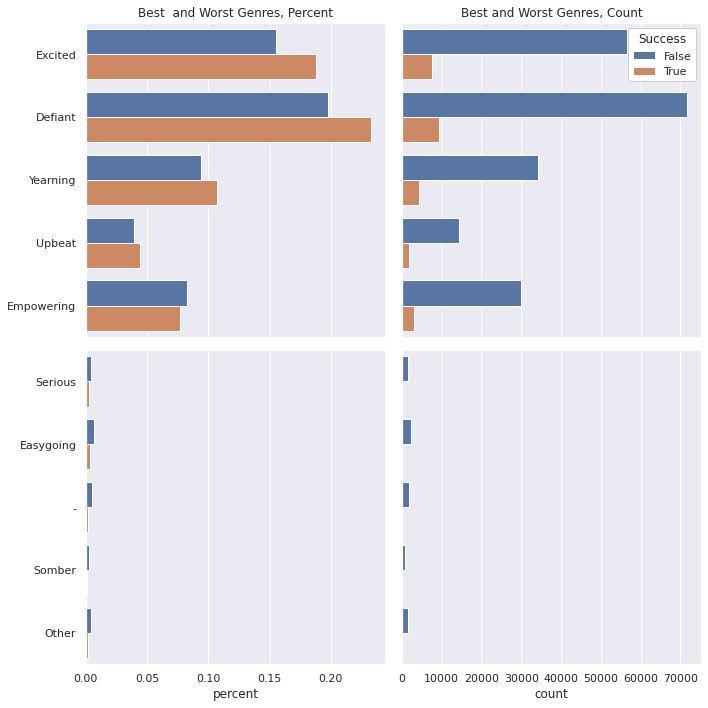

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col', sharey='row')
ind_feature = 'mood_1'
target = 'new_success'

genre_list = chisum.loc[(chisum['feature'] == ind_feature)
                       & (chisum['reject null'] == True)].sort_values('multiplier', ascending=False)['group'].values

chisum.loc[(chisum['feature'] == ind_feature)
                       & (chisum['reject null'] == True)].sort_values('multiplier', ascending=False).to_excel('table.xlsx')

dff = pd.DataFrame(df.groupby([ind_feature])[target].value_counts(sort=False))
dff.columns = ['percent']
dff = dff.reset_index()
dff.loc[dff[target] == True, 'percent'] = dff.loc[dff[target] == True, 'percent'] / dff.loc[dff[target] == True, 'percent'].sum() 
dff.loc[dff[target] == False, 'percent'] = dff.loc[dff[target] == False, 'percent'] / dff.loc[dff[target] == False, 'percent'].sum() 
dff = dff.set_index(ind_feature).loc[genre_list,:]
dff = dff.reset_index()

sns.barplot(data=dff.iloc[:10,:], hue=target, y=ind_feature, x='percent', ax=ax[0,0])
ax[0,0].set_title('Best  and Worst Genres, Percent')
ax[0,0].set_ylabel('')
ax[0,0].set_xlabel('')
sns.barplot(data=dff.iloc[-10:,:], hue=target, y=ind_feature, x='percent', ax=ax[1,0])
# ax[1,0].set_title('Worst Primary Genres')
ax[1,0].set_ylabel('')

dff = pd.DataFrame(df.groupby([ind_feature])[target].value_counts(sort=False))
dff.columns = ['count']
dff = dff.reset_index()
# dff.loc[dff[target] == True, 'percent'] = dff.loc[dff[target] == True, 'percent'] / dff.loc[dff[target] == True, 'percent'].sum() 
# dff.loc[dff[target] == False, 'percent'] = dff.loc[dff[target] == False, 'percent'] / dff.loc[dff[target] == False, 'percent'].sum() 
dff = dff.set_index(ind_feature).loc[genre_list,:]
dff = dff.reset_index()

# fix, ax = plt.subplots(2, 2, figsize=(10,10))
sns.barplot(data=dff.iloc[:10,:], hue=target, y=ind_feature, x='count', ax=ax[0,1])
ax[0,1].set_title('Best and Worst Genres, Count')
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')
sns.barplot(data=dff.iloc[-10:,:], hue=target, y=ind_feature, x='count', ax=ax[1,1])
# ax[1,1].set_title('Worst Primary Genres')
ax[1,1].set_ylabel('')
plt.tight_layout()

ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[0,1].legend(framealpha=1, facecolor='white', title="Success")

fig.savefig("new_categorical_dependency_mood.svg")

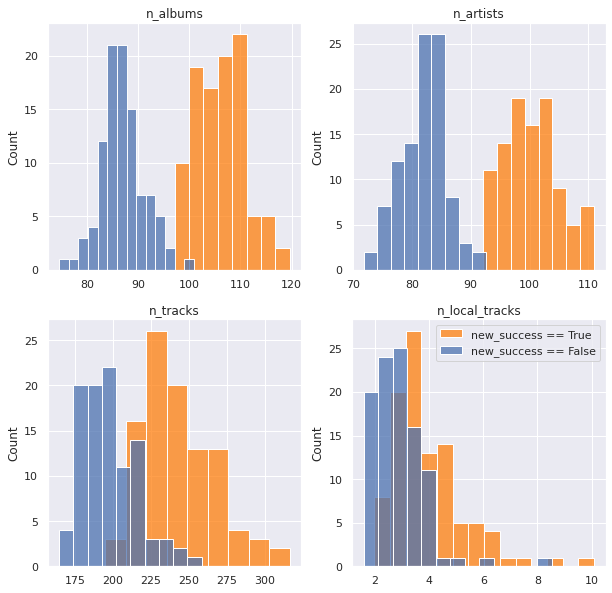

In [24]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
con_features = ['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']
chidf = pd.DataFrame()
target = "new_success"
chidf[target] = df[target]
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind, ax in zip(con_features, [ax1, ax2, ax3, ax4]):
    chidf[ind] = df[ind]
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} == True", ax=ax)
    sns.histplot(b, label=f"{target} == False", ax=ax)
    ax.set_title(ind)

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

welchsum.to_excel("new_ttest.xlsx")
ax.legend()
fig.savefig("new_ttest.svg")

In [ ]:
chidf = pd.DataFrame()
target = "success"
chidf[target] = df[target]
# chidf.iloc[:int(chidf.shape[0]/2),:] = True
# chidf.iloc[int(chidf.shape[0]/2):,:] = False
# quant_value = 0.99
# tar_value = np.quantile(chidf[target], quant_value)
# chidf[target] = chidf[target] > tar_value
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in con_features:
    # ind = con_features[0]
    chidf[ind] = df[ind]

    # for grp_label in df[ind].unique():
    # try:
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} == True")
    sns.histplot(b, label=f"{target} == False")
    plt.title(ind)
    plt.legend()
    plt.show()
    # except:
    #     pass

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

### Considering outliers

In [ ]:
df = df.loc[df[targets].apply(lambda x: (x < 3*x.std()) if (x.dtype == int or x.dtype == float) else x).all(axis=1)]

In [ ]:
df = df.loc[df['owner'] != 'spotify']

### Multiple Criteria for Success

In [ ]:
df['success'] = df[sub_targets].apply(lambda x: x > np.quantile(x, 0.75)).all(axis=1)

In [ ]:
chidf = pd.DataFrame()
target = 'success'
chidf[target] = df[target]
# quant_value = 0.90
# tar_value = np.quantile(chidf[target], quant_value)
# chidf[target] = chidf[target] > tar_value
chisum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]

    for grp_label in df[ind].unique():
    # grp_label = df[ind].unique()[0]
        try:
            cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
            chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
            ratio = cTable[1]/cTable[0]
            pos = ratio[1]/ratio[0]
            chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
        except:
            pass

chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

In [ ]:
chisum.loc[chisum['reject null'] == True].sort_values('multiplier', ascending=False)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col', sharey='row')

genre_list = chisum.loc[chisum['feature'] == 'genre_1'].sort_values('multiplier', ascending=False)['group'].values
dff = pd.DataFrame(df.groupby(['genre_1'])['success'].value_counts(sort=False))
dff.columns = ['percent']
dff = dff.reset_index()
dff.loc[dff['success'] == True, 'percent'] = dff.loc[dff['success'] == True, 'percent'] / dff.loc[dff['success'] == True, 'percent'].sum() 
dff.loc[dff['success'] == False, 'percent'] = dff.loc[dff['success'] == False, 'percent'] / dff.loc[dff['success'] == False, 'percent'].sum() 
dff = dff.set_index('genre_1').loc[genre_list,:]
dff = dff.reset_index()

sns.barplot(data=dff.iloc[:10,:], hue='success', y='genre_1', x='percent', ax=ax[0,0])
ax[0,0].set_title('Best  and Worst Genres, Percent')
ax[0,0].set_ylabel('')
ax[0,0].set_xlabel('')
sns.barplot(data=dff.iloc[-10:,:], hue='success', y='genre_1', x='percent', ax=ax[1,0])
# ax[1,0].set_title('Worst Primary Genres')
ax[1,0].set_ylabel('')

dff = pd.DataFrame(df.groupby(['genre_1'])['success'].value_counts(sort=False))
dff.columns = ['count']
dff = dff.reset_index()
# dff.loc[dff['success'] == True, 'percent'] = dff.loc[dff['success'] == True, 'percent'] / dff.loc[dff['success'] == True, 'percent'].sum() 
# dff.loc[dff['success'] == False, 'percent'] = dff.loc[dff['success'] == False, 'percent'] / dff.loc[dff['success'] == False, 'percent'].sum() 
dff = dff.set_index('genre_1').loc[genre_list,:]
dff = dff.reset_index()

# fix, ax = plt.subplots(2, 2, figsize=(10,10))
sns.barplot(data=dff.iloc[:10,:], hue='success', y='genre_1', x='count', ax=ax[0,1])
ax[0,1].set_title('Best and Worst Genres, Count')
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')
sns.barplot(data=dff.iloc[-10:,:], hue='success', y='genre_1', x='count', ax=ax[1,1])
# ax[1,1].set_title('Worst Primary Genres')
ax[1,1].set_ylabel('')
plt.tight_layout()

ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[0,1].legend(framealpha=1, facecolor='white', title="Success")

fig.savefig("categorical_dependency.svg")

In [ ]:
ind = 'n_tracks'
target = 'wau'
mean_wau_vs_track = []
for track in range(1, 201):
    means = [] 
    for i in range(10):
        boot = random.sample(
                    list(
                        df.loc[
                            (df['success'] == True) 
                            & (df[ind] == track)
                        ][target].values),
                    k=min(len(list(
                        df.loc[
                            (df['success'] == True) 
                            & (df[ind] == track)
                        ][target].values)), 1000))
        means.append(np.mean(boot))
    mean_wau_vs_track.append(np.mean(means))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(range(len(mean_wau_vs_track)), mean_wau_vs_track, ls='', marker='.')
# ax.set_ylim(0,5)

In [ ]:
len(df.loc[
                            (df['success'] == True) 
                            & (df[ind] == track)
                        ][target].values)

### Dependency

In [ ]:
master = pd.DataFrame()
for target in new_metrics:
    # target = sub_targets[0]
    chidf = pd.DataFrame()
    chidf[target] = df[target]
    quant_value = 0.90
    tar_value = np.quantile(chidf[target], quant_value)
    tar_value = 0.8
    chidf[target] = chidf[target] >= tar_value
    chisum = pd.DataFrame()
    cutoff = 0.0001
    pop = chidf[target].values

    for ind in des_features:
        # ind = des_features[0]
        chidf[ind] = df[ind]

        for grp_label in df[ind].unique():
        # grp_label = df[ind].unique()[0]
            try:
                cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
                chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
                ratio = cTable[1]/cTable[0]
                pos = ratio[1]/ratio[0]
                chisum = pd.concat([chisum, pd.DataFrame([[target, ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
            except:
                pass

    chisum.columns = ['target', 'feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
    chisum = chisum.sort_values('p-value').reset_index(drop=True)
    # chisum = chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] > 2)].sort_values('multiplier', ascending=False)
    master = pd.concat((master, chisum))
    
master

In [ ]:
master.loc[(master['reject null'] == True) & (master['multiplier'] > 1.5)]

In [ ]:
master.loc[(master['reject null'] == True) & (master['multiplier'] < .5)]

In [ ]:
new_master = pd.DataFrame()
for target in new_metrics:
    # target = sub_targets[2]
    chidf = pd.DataFrame()
    chidf[target] = df[target]
    chidf['n_tracks'] = df['n_tracks']
    quant_value = 0.90
    tar_value = np.quantile(chidf[target], quant_value)
    tar_value = 0.8
    chidf[target] = chidf[target] >= tar_value
    welchsum = pd.DataFrame()
    cutoff = 0.0001
    pop = chidf[target].values

    for ind in con_features:
        # ind = con_features[0]
        chidf[ind] = df[ind]

        # for grp_label in df[ind].unique():
        # try:
        a = []
        b = []
        for i in range(100):
            boot1 = random.sample(
                        list(
                            chidf.loc[
                                (chidf[target] == True)
                                & (chidf['n_tracks'] > 9)
                                & (chidf['n_tracks'] < 999)
                            ][ind].values),
                        k=1000)
            boot2 = random.sample(
                        list(
                            chidf.loc[
                                (chidf[target] == False)
                                & (chidf['n_tracks'] > 9)
                                & (chidf['n_tracks'] < 999)
                            ][ind].values),
                        k=1000)
            a.append(np.mean(boot1))
            b.append(np.mean(boot2))
        testt, p = stats.ttest_ind(a, b, equal_var=False)
        a_avg = np.mean(a)
        b_avg = np.mean(b)
        welchsum = pd.concat([welchsum, pd.DataFrame([[target, ind, testt, p, a_avg, b_avg, p<cutoff]])])
        sns.histplot(a, color='tab:orange', label=f"{target} >= {tar_value:.0f}")
        sns.histplot(b, label=f"{target} < {tar_value:.0f}")
        plt.title(f"{target}, {ind}")
        plt.legend()
        plt.show()
        # except:
        #     pass

    welchsum.columns = ['target', 'feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
    welchsum = welchsum.sort_values('p-value').reset_index(drop=True)
    new_master = pd.concat((new_master, welchsum))
new_master

## Conclusions

### Discrete, Independent Variables

We note that there is class imbalance in the discrete independent variables:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

dff = pd.DataFrame(df[des_features[0]].value_counts()).join(
    pd.DataFrame(df[des_features[1]].value_counts())).join(
    pd.DataFrame(df[des_features[2]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['mood', 'order', 'count']
sns.barplot(data=dff, hue='order', y='mood', x='count', orient='h', ax=ax[0])

dff = pd.DataFrame(df[des_features[3]].value_counts()).join(
    pd.DataFrame(df[des_features[4]].value_counts())).join(
    pd.DataFrame(df[des_features[5]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['genre', 'order', 'count']
sns.barplot(data=dff, hue='order', y='genre', x='count', orient='h', ax=ax[1])

plt.tight_layout()

This class imbalance can have a variety of effects (and might be derived from a variety of sources).

For example, users will have more choice when listening to popular genres likeIndie Rock and Rap, and less choice with genres like Blues and Easy listening. As it so happens, when we look to the relationship between genre/mood and the dependent variables, many of the genre/moods with smaller class sizes will have a positive multiplier effect on the dependent variable

### Continuous, Independent Variables

The four continuous variables of focus in this dataset are highly tailed. Due to this, our statistical tests will require bootstrapping.

removed items: 404


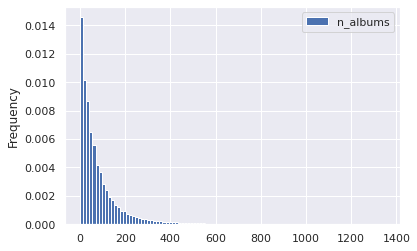

removed items: 405


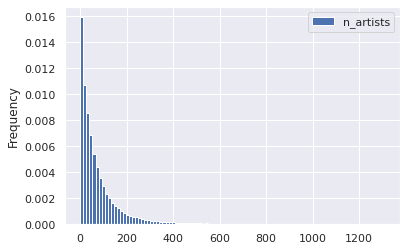

removed items: 404


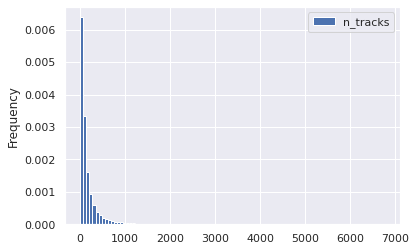

removed items: 406


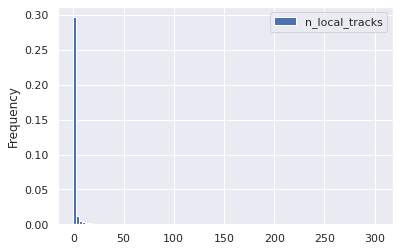

In [22]:
quant = 0.999
con_features = ['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']
for target in con_features:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    removed = df.loc[~(df[target] < cutoff)]
    print(f"removed items: {removed.shape[0]}")
    y.plot(kind='hist', y=target, bins=100, density=True)
    plt.show()

an example of bootstrapping `n_albums`

In [ ]:
means = []
ind = con_features[0]
for i in range(100):
    boot = random.sample(
                list(
                    df.loc[
                        (df[ind] > 9) 
                        & (df[ind] < 999)
                    ][ind].values),
                k=1000)
    means.append(np.mean(boot))
stuff = plt.hist(means, bins=100, density=True)

### Discrete, Dependent Variables

For the purposes of investigating a "successful" playlist, there are 5 primary metrics:

In [ ]:
targets

In [ ]:
df[sub_targets].describe().round(1).to_excel("file.xlsx")

and "top" performers in each of these metrics were based on top 10% and top 1% quantiles:

In [ ]:
print('p99 targets')
for target in sub_targets:
    space = ' '* (20 - len(str(target)))
    print(f"{target}: {space} {np.quantile(df[target], 0.99)}")
print()
print('p90 targets')
for target in sub_targets:
    space = ' '* (20 - len(str(target)))
    print(f"{target}: {space} {np.quantile(df[target], 0.90)}")

You can imagine with these metrics, some concerns are:

* what if a playlist was made in the current month, or even current day?
    * playlist is not properly represented by the data
* how do we normalize by playlists that already have a high visibility? i.e. what if a playlist is "good" but just isn't getting noticed?
    * can compute conversion metrics:
        * 30 second listens / total listens
        * mau both months / mau previous month
        
While noting these shortcomings, to keep the analysis focused I singled out the previously mentioned targets, with a focus on `monthly_stream30s` as the north star metric. `monthly_stream30s` is advantageous as a nort star metric since it contains data from the entire month (reducing variance) only contains relevant listens (greater than 30 seconds long). Some disadvantages of this metric are that it doesn't account for just a few listeners who may be providing the majority of listens, and playlists that were made in the current month will be undervalued.

### Dependency

#### Chi Square

In the chi-square test, the contigency table was used to calculate a `multiplier` effect. This is a ratio of ratios: the count of upper quantile over bottom quantile for the given group over the count of upper quantile over bottom quantile for non-group. In other words, it articulates how much more likely a sample in the given group is likely to be in the upper quantile vs a sample not in the given group

In [ ]:
chisq_results = pd.read_csv("chi_square_results.csv", index_col=0)
chisq_results.head()

In [ ]:
chisq_results['target'].unique()

In [ ]:
chisq_results['upper q'].unique()

Taking together the five targets, the two upper quantiles, and the six categorical independent variables, we can identify which group occured the most frequently as a variable of influence:

In [ ]:
chisq_results.loc[(chisq_results['feature'].str.contains('genre'))
                & (chisq_results['group'] != '-')]['group'].value_counts()

Using these value counts as a "rank" we can then groupby this rank and see how each group is influencing the propensity to be in the upper quadrant

Taking "Romantic" as an example, we see that it's multiplier effect is relatively consistent across the five targets and two quantiles:

In [ ]:
sort_key = {i: j for i,j in zip(chisq_results['group'].value_counts().index.values, range(chisq_results['group'].nunique()))}
chisq_results['rank'] = chisq_results['group'].apply(lambda x: sort_key[x])
chisq_results.sort_values('rank', inplace=True)
# chisq_results.drop('rank', axis=1, inplace=True)
chisq_results.loc[chisq_results['group'] != '-'][:20]

In [ ]:
chisq_results.loc[(chisq_results['group'] == 'Traditional')
                 & (chisq_results['target'] == 'monthly_stream30s')]

Let's use this idea of average multiplier effect, and average chi-square statistic to summarize by group.

Sorting by the test statistic, we see the top 5 most influential groups:

In [ ]:
chisq_results.groupby('group')[['chi', 'multiplier', 'rank']].mean().sort_values('chi', ascending=False)[:10]

Sorting instead by the multiplier, we can see which group has the _heaviest_ influence

In [ ]:
chisq_results.groupby('group')[['chi', 'multiplier', 'rank']].mean().sort_values('multiplier', ascending=False)[:10]

Sorting instead by rank, we see which groups show up most frequently

In [ ]:
chisq_results.groupby('group')[['chi', 'multiplier', 'rank']].mean().sort_values('rank', ascending=True)[:10]

In [ ]:
chisq_results.loc[chisq_results['target'] == 'monthly_stream30s']

It creates some fog to jumble together mood/genres this way. We can instead separate them and ask questions like:

##### What is the most influential primary genre on monthly streams over 30 seconds?

Answer: Children's followed by Latin

Reason: both genre's appear as influential in other guardrail metrics (high rank), have high test statistics, and are influential in both p99 and p90 with multiplier effects of [4.8, 2.6] and [3.1, 2.1], respectively.

In [ ]:
chisq_results.loc[(chisq_results['feature'] == 'genre_1')
                 & (chisq_results['target'] == 'monthly_stream30s')]

##### What is the most influential primary mood on monthly streams over 30 seconds?

Answer: Romantic and Lively

Reason: Romantic and Lively moods appear multiple times as highly influential (high rank) they have high multipliers. A contendent may be Tender, as it has a high multiplier effect as well at 3.75

In [ ]:
chisq_results.loc[(chisq_results['feature'] == 'mood_1')
                 & (chisq_results['target'] == 'monthly_stream30s')]

##### Which Categorical Feature is most influential overall?

Answer: genre_1, followed by genre_2 and mood_1

Reason: we see that these features appear multiple times across the 5 different targets and 2 different quantiles

In [ ]:
chisq_results['feature'].value_counts()

##### What are the shortcomings of this analysis?

We haven't taken into account confounding variables. For example, perhaps Latin genre is typically associated with Lively mood. Then which variable is it that actually contributes to a highly performing playlist? We have strategies for dealing with this. We can stratify the confounding variables by over or under sampling. We can also consider them together in a forward selection logistic model. We will take the latter approach later on in the analysis.

We haven't considered the categorical variables alongside the continuous variables, so we don't know how they fit overall in terms of relative improtance. We will approach this the same way as the confounding variables issue, and incorporate all variables in a logistic regression.

#### t-Test

In [ ]:
ttest_results = pd.read_csv("t_test_results.csv", index_col=0)
ttest_results.head()

#### Models

In [ ]:
log_results = pd.read_csv("../../scripts/fwd_selection_results.txt", header=None, index_col=0)
log_results.columns = ['feature', 'pseudo r2']
log_results.reset_index(inplace=True, drop=True)
log_results.drop(0, axis=0, inplace=True)
log_results

In [ ]:
target = "monthly_stream30s"
y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = 0
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              & (labels <= np.quantile(y, quant))] = 1
        weights[(y > np.quantile(y, prev))
              & (y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

basemodel = pd.read_csv("../../scripts/basemodel.csv", index_col = 0)
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
res_df